<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 2: Prediction of HDB Resale Flat Prices
Author: Edmond Ang

## Contents
* [1. Improved Model Prediction](#1.-Improved-Model-Prediction)
    * [1.1. Imports](#1.1.-Imports)
    * [1.2. Read datasets](#1.2.-Read-datasets)
    * [1.3. EDA: Correlation](#1.3.-EDA:-Correlation)
* [2. Model Prediction: with All Data](#2.-Model-Prediction:-with-All-Data)
    * [2.1. Model prep: train-test split](#2.1.-Model-prep:-train-test-split)
    * [2.2. Model prep: scale and one-hot encode (ohe)](#2.2.-Model-prep:-scale-and-one-hot-encode-(ohe))
    * [2.3. Model prep: make train and test datasets whole](#2.3.-Model-prep:-make-train-and-test-datasets-whole)
    * [2.4. Instantiate model](#2.4.-Instantiate-model)
    * [2.5. Cross validation](#2.5.-Cross-validation)
* [3. Model Prediction: with Continuous Features with abs(P-Value) >0.3](#3.-Model-Prediction:-with-Continuous-Features-with-abs(P-Value)->0.3)
    * [3.1. Model prep: train-test split](#3.1.-Model-prep:-train-test-split)
    * [3.2. Model prep: scale and one-hot encode (ohe)](#3.2.-Model-prep:-scale-and-one-hot-encode-(ohe))
    * [3.3. Model prep: make train and test datasets whole](#3.3.-Model-prep:-make-train-and-test-datasets-whole)
    * [3.4. Cross validation](#3.4.-Cross-validation)
* [4. Model Prediction: with Continuous Features with abs(P-Value) >0.1](#4.-Model-Prediction:-with-Continuous-Features-with-abs(P-Value)->0.1)
    * [4.1. Model prep: train-test split](#4.1.-Model-prep:-train-test-split)
    * [4.2. Model prep: scale and one-hot encode (ohe)](#4.2.-Model-prep:-scale-and-one-hot-encode-(ohe))
    * [4.3. Model prep: make train and test datasets whole](#4.3.-Model-prep:-make-train-and-test-datasets-whole)
    * [4.4. Cross validation](#4.4.-Cross-validation)
* [5. Picking the Best Model](#5.-Picking-the-Best-Model)
    * [5.1. Comparing all cross-val scores](#5.1.-Comparing-all-cross-val-scores)
    * [5.2. Fitting the best performing model](#5.2.-Fitting-the-best-performing-model)
    * [5.3. Scale and ohe test.csv](#5.3.-Scale-and-ohe-test.csv)
    * [5.4. Predict](#5.4.-Predict)
    * [5.5. Export](#5.5.-Export)
* [6. Conclusion](#6.-Conclusion)
    * [6.1. Addressing the problem statement](#6.1.-Addressing-the-problem-statement)
    * [6.2. Learning points](#6.2.-Learning-points)
    * [6.3. Areas for future improvement](6.3.-Areas-for-future-improvement)

---
## 1. Improved Model Prediction
---

Overview of methodology:
1. Test if the filtering of hdb training dataset through Pearson correlation coefficients will improve model predictions
    * Use Pearson correlation coef to pick out 3 types of filtered df: 
        * abs(P-Value) > 0 (i.e. use all data), 
        * abs(P-Value) > 0.1 and 
        * abs(P-Value) > 0.3
2. For the 3 dfs, calculate and compare the cross validation scores of linear regression, lasso cross-validation (lassocv), ridge cross-validation (ridgecv) and elastic net cross-validation models
3. Fit the best performing model and use it for prediction

### 1.1. Imports

In [146]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import r2_score

### 1.2. Read datasets

In [147]:
hdb_train_df = pd.read_csv('output/cleaned_baseline_hdb_train.csv')
hdb_test_df = pd.read_csv('output/cleaned_baseline_hdb_test.csv')
id_df = pd.read_csv('output/cleaned_hdb_test_id.csv')

In [148]:
pd.set_option('display.max_columns', None)  # to see all columns
print(hdb_train_df.head())

              town  floor_area_sqm  resale_price  Tranc_Year  Tranc_Month  \
0  KALLANG/WHAMPOA            90.0      680000.0        2016            5   
1           BISHAN           130.0      665000.0        2012            7   
2      BUKIT BATOK           144.0      838000.0        2013            7   
3           BISHAN           103.0      550000.0        2012            4   
4           YISHUN            83.0      298000.0        2017           12   

   mid_storey       full_flat_type  hdb_age  max_floor_lvl  year_completed  \
0          11       4 ROOM Model A       15             25            2005   
1           8      5 ROOM Improved       34              9            1987   
2          14  EXECUTIVE Apartment       24             16            1996   
3           3       4 ROOM Model A       29             11            1990   
4           2    4 ROOM Simplified       34              4            1987   

   residential  commercial  market_hawker  multistorey_carpark  \
0 

### 1.3. EDA: Correlation

* tried plotting heatmap, but the graph is too difficult to view

<AxesSubplot: >

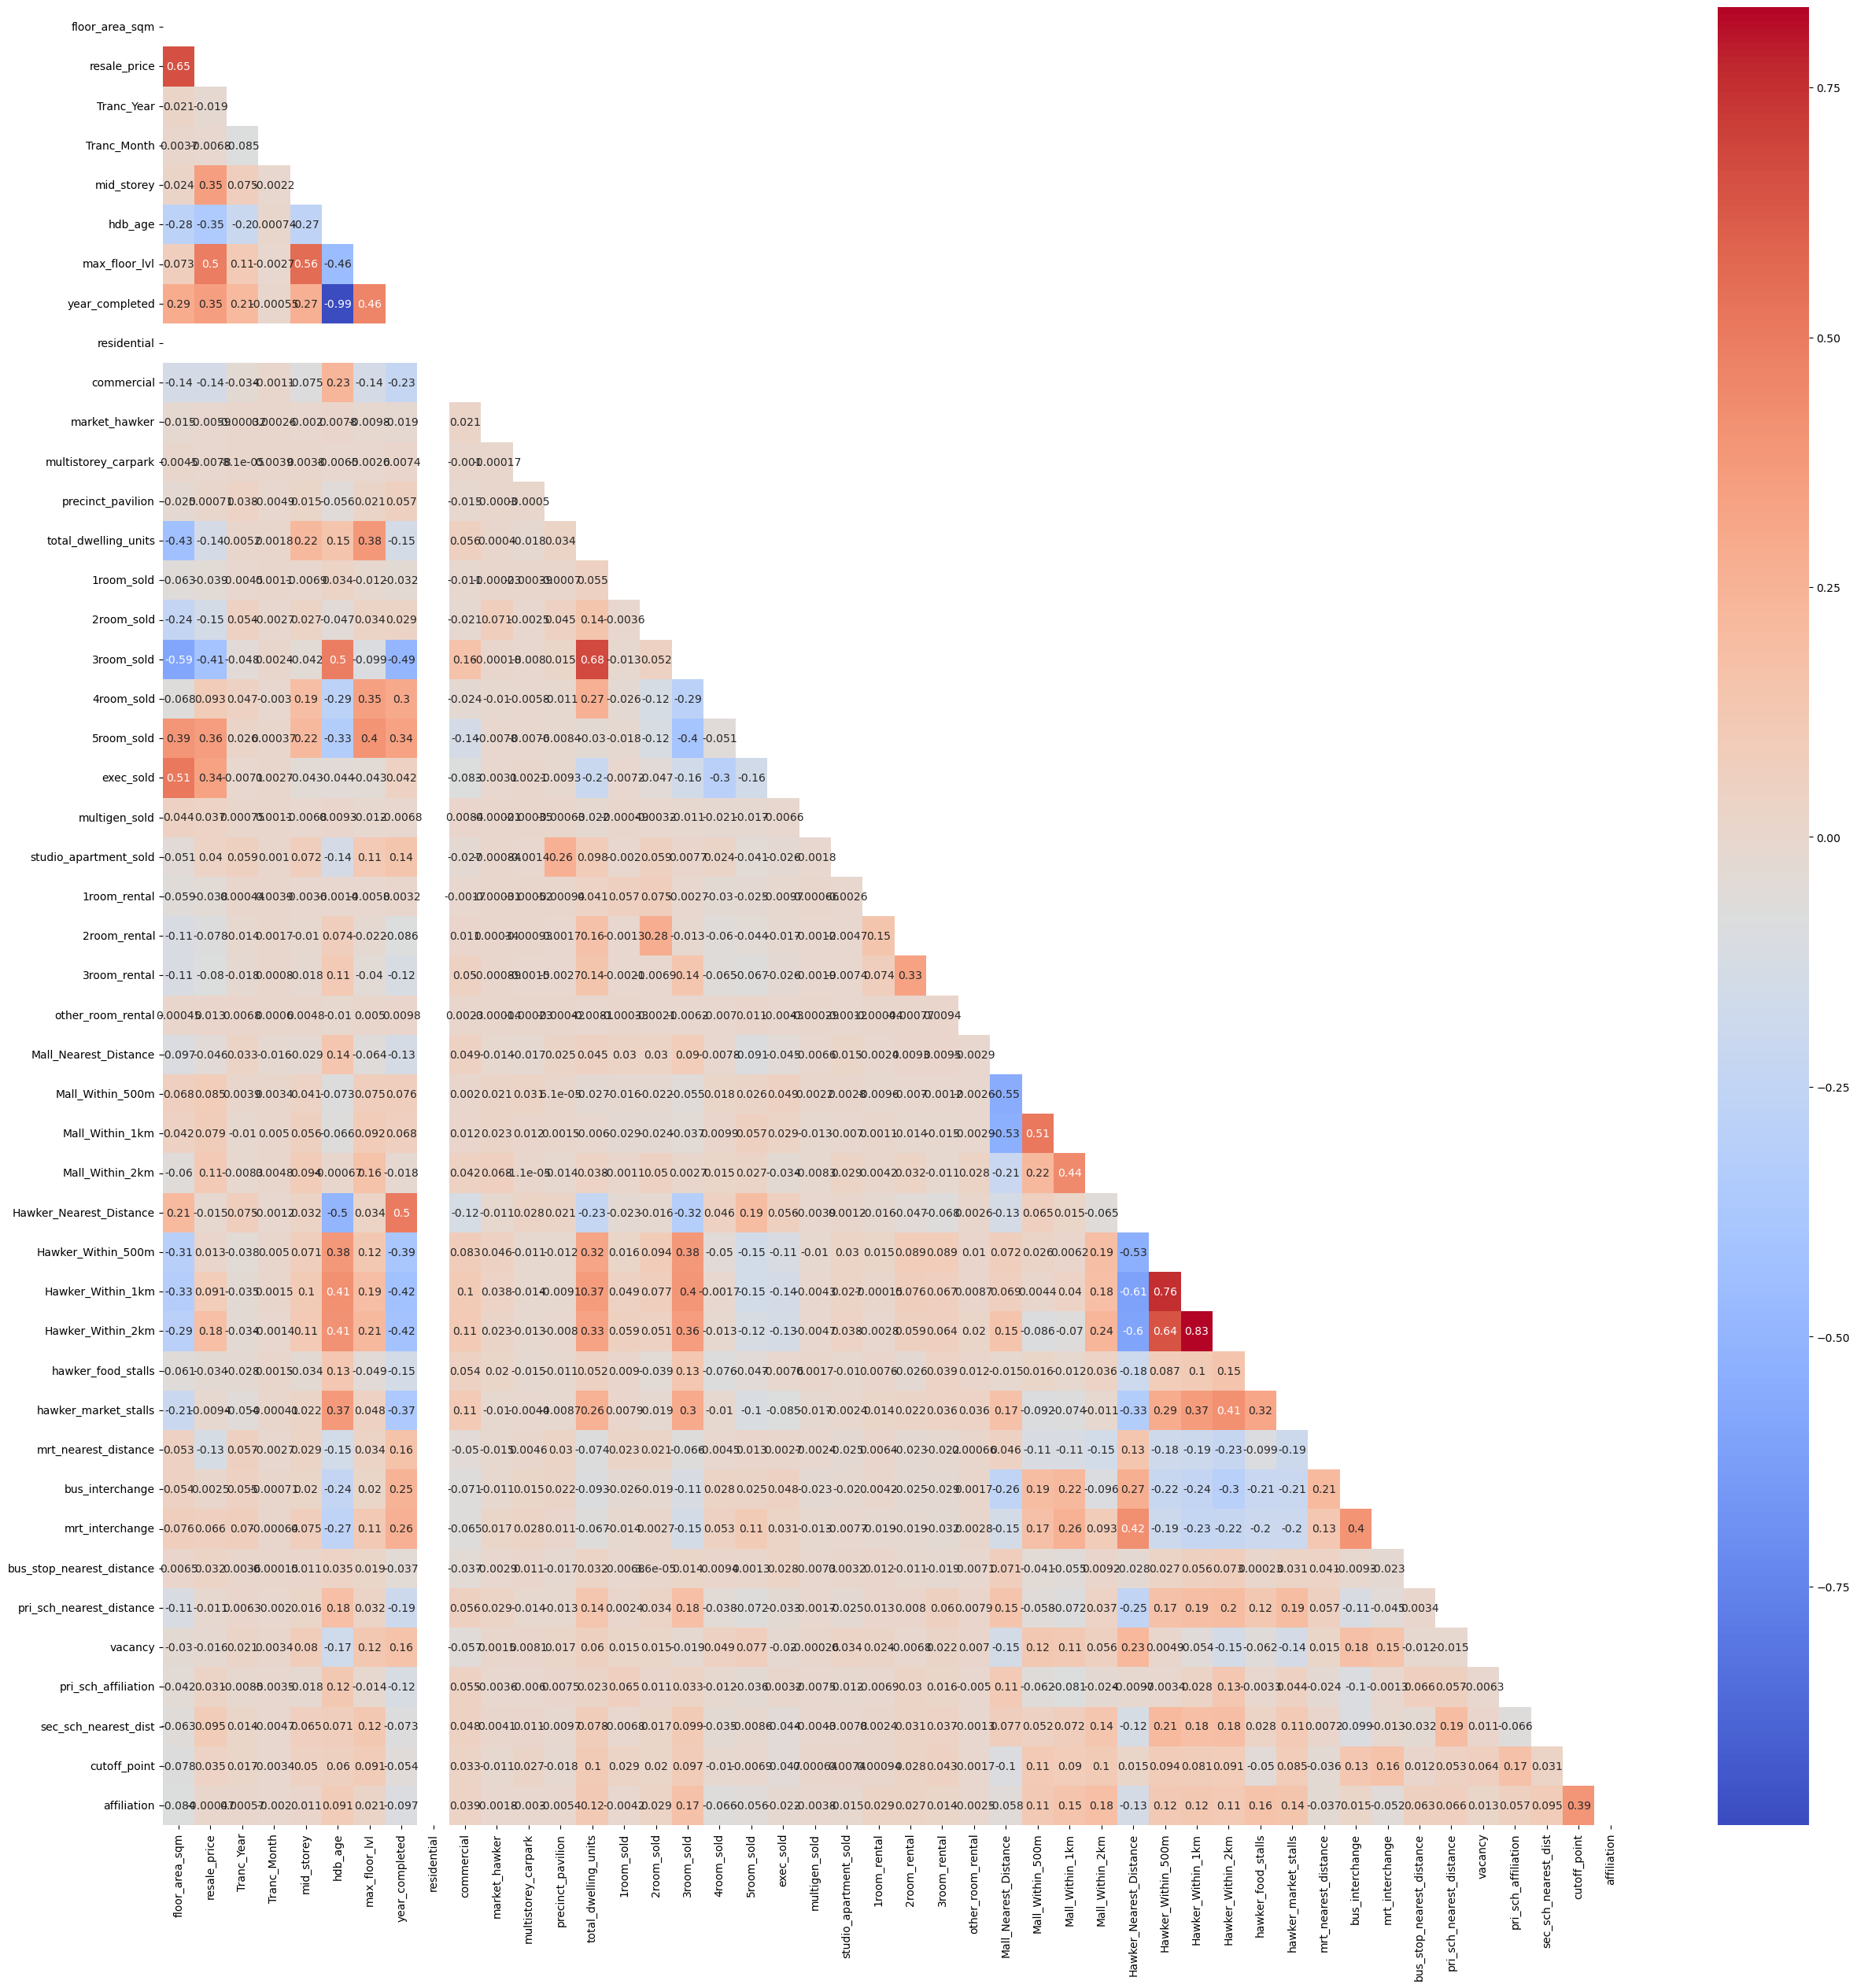

In [149]:
plt.figure(figsize=(30,30))
corr = hdb_train_df.corr(numeric_only = True)

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask = mask, annot = True, cmap = 'coolwarm')  # graph is too difficult to view

* checking out the corr between y and continuous x variables

In [150]:
# checking out the corr between y and continuous x variables
hdb_train_df.select_dtypes(include=['int64', 'float64']).corr(numeric_only=True)['resale_price']

floor_area_sqm               0.654120
resale_price                 1.000000
Tranc_Year                  -0.019146
Tranc_Month                 -0.006823
mid_storey                   0.353213
hdb_age                     -0.350337
max_floor_lvl                0.495650
year_completed               0.353698
total_dwelling_units        -0.140725
1room_sold                  -0.039434
2room_sold                  -0.145287
3room_sold                  -0.410368
4room_sold                   0.092600
5room_sold                   0.359434
exec_sold                    0.337500
multigen_sold                0.037406
studio_apartment_sold        0.040312
1room_rental                -0.037993
2room_rental                -0.077548
3room_rental                -0.079965
other_room_rental            0.013049
Mall_Nearest_Distance       -0.045966
Mall_Within_500m             0.085151
Mall_Within_1km              0.078815
Mall_Within_2km              0.108648
Hawker_Nearest_Distance     -0.014537
Hawker_Withi

* isolating the variables with varied p-value scores

In [151]:
p_val = hdb_train_df.corr(numeric_only=True)['resale_price'].sort_values(ascending=False)  # sorted values for easy reading
p_val_high_50 = p_val[abs(p_val)>0.5]
print('p-value > 0.5\n', p_val_high_50, '\n')  # 0.5 seems like too high a benchmark, only have 'floor_area_sqm'

p_val_high_30 = p_val[abs(p_val)>0.3]
print('p-value > 0.3\n', p_val_high_30, '\n') 
print(p_val_high_30.index)

p_val_high_10 = p_val[abs(p_val)>0.1]
print('p-value > 0.1\n', p_val_high_10, '\n')

p-value > 0.5
 resale_price      1.00000
floor_area_sqm    0.65412
Name: resale_price, dtype: float64 

p-value > 0.3
 resale_price      1.000000
floor_area_sqm    0.654120
max_floor_lvl     0.495650
5room_sold        0.359434
year_completed    0.353698
mid_storey        0.353213
exec_sold         0.337500
hdb_age          -0.350337
3room_sold       -0.410368
Name: resale_price, dtype: float64 

Index(['resale_price', 'floor_area_sqm', 'max_floor_lvl', '5room_sold',
       'year_completed', 'mid_storey', 'exec_sold', 'hdb_age', '3room_sold'],
      dtype='object')
p-value > 0.1
 resale_price            1.000000
floor_area_sqm          0.654120
max_floor_lvl           0.495650
5room_sold              0.359434
year_completed          0.353698
mid_storey              0.353213
exec_sold               0.337500
Hawker_Within_2km       0.183168
Mall_Within_2km         0.108648
mrt_nearest_distance   -0.128222
commercial             -0.140183
total_dwelling_units   -0.140725
2room_sold        

* filter the original hdb_train_df to only the continuous features with p-value >0.3 & >0.1
* will not filter the df with continuous features with p-value >0.5, as there's only 1 feature left with 0.65 pearson corr coef, which intuitively tells me that it will under-perform

In [152]:
features_30 = p_val_high_30.index
features_10 = p_val_high_10.index

hdb_train_df_30 = hdb_train_df[features_30]
hdb_train_df_10 = hdb_train_df[features_10]

---
## 2. Model Prediction: with All Data
---

### 2.1. Model prep: train-test split

In [153]:
X = hdb_train_df.drop(columns=['resale_price'])
y = hdb_train_df['resale_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)
print(len(X_train), len(X_test), len(y_train), len(y_test))
print(len(X_test.columns))

112975 37659 112975 37659
49


### 2.2. Model prep: scale and one-hot encode (ohe)
* separate continuous and categorical features

In [154]:
# separate column names by dtype
X_train_cat = X_train.select_dtypes(include=['object','bool']).columns
X_train_cont = X_train.select_dtypes(include=['int64', 'float64']).columns
X_test_cat = X_test.select_dtypes(include=['object','bool']).columns
X_test_cont = X_test.select_dtypes(include=['int64', 'float64']).columns

print(X_train_cat)
print(X_train_cont)

Index(['town', 'full_flat_type', 'residential', 'commercial', 'market_hawker',
       'multistorey_carpark', 'precinct_pavilion', 'pri_sch_name',
       'sec_sch_name'],
      dtype='object')
Index(['floor_area_sqm', 'Tranc_Year', 'Tranc_Month', 'mid_storey', 'hdb_age',
       'max_floor_lvl', 'year_completed', 'total_dwelling_units', '1room_sold',
       '2room_sold', '3room_sold', '4room_sold', '5room_sold', 'exec_sold',
       'multigen_sold', 'studio_apartment_sold', '1room_rental',
       '2room_rental', '3room_rental', 'other_room_rental',
       'Mall_Nearest_Distance', 'Mall_Within_500m', 'Mall_Within_1km',
       'Mall_Within_2km', 'Hawker_Nearest_Distance', 'Hawker_Within_500m',
       'Hawker_Within_1km', 'Hawker_Within_2km', 'hawker_food_stalls',
       'hawker_market_stalls', 'mrt_nearest_distance', 'bus_interchange',
       'mrt_interchange', 'bus_stop_nearest_distance',
       'pri_sch_nearest_distance', 'vacancy', 'pri_sch_affiliation',
       'sec_sch_nearest_dist', 'c

* scale and ohe the separate features

In [155]:
ss = StandardScaler()
ohe = OneHotEncoder(sparse=False, drop='first')

# scale and one-hot encode based on columns defined above
Z_train_ss = ss.fit_transform(X_train[X_train_cont])
Z_train_ohe = ohe.fit_transform(X_train[X_train_cat])
Z_test_ss = ss.transform(X_test[X_test_cont])
Z_test_ohe = ohe.transform(X_test[X_test_cat])

### 2.3. Model prep: make train and test datasets whole

In [187]:
Z_train = np.concatenate([Z_train_ss, Z_train_ohe], axis=1)
Z_test = np.concatenate([Z_test_ss, Z_test_ohe], axis=1)
print(Z_train.shape)  # 420 cols is over the rule-of-thumb value of 388 cols for curse of dimensionality
# but it is okay, perhaps lassocv will help to reduce the number of dimensions

(112975, 420)


### 2.4. Instantiate model

In [157]:
lr = LinearRegression()
lassocv = LassoCV()
ridgecv = RidgeCV(alphas=np.linspace(.01, 10, 100))  # used 
enetcv = ElasticNetCV(alphas=np.linspace(0.1,1.0,100))

### 2.5. Cross validation

In [158]:
lr_scores_all = cross_val_score(lr, Z_train, y_train, cv=3).mean()
lassocv_scores_all = cross_val_score(lassocv, Z_train, y_train, cv=3).mean()
ridgecv_scores_all = cross_val_score(ridgecv, Z_train, y_train, cv=3).mean()
enetcv_scores_all = cross_val_score(enetcv, Z_train, y_train, cv=3).mean()

print('lr score (with all data): ', lr_scores_all)
print('lassocv score (with all data): ', lassocv_scores_all)
print('ridgecv score (with all data): ', ridgecv_scores_all)
print('enetcv score (with all data): ', enetcv_scores_all)

lr score (with all data):  -1.776360032092452e+16
lassocv score (with all data):  0.8960297957019003
ridgecv score (with all data):  0.9113749257359093
enetcv score (with all data):  0.8480892548418252


---
## 3. Model Prediction: with Continuous Features with abs(P-Value) >0.3
---

### 3.1. Model prep: train-test split

In [159]:
X_30 = hdb_train_df_30.drop(columns=['resale_price'])
y_30 = hdb_train_df_30['resale_price']
X_train_30, X_test_30, y_train_30, y_test_30 = train_test_split(X_30, y_30, random_state = 42)
print(len(X_train_30), len(X_test_30), len(y_train_30), len(y_test_30))
print(len(X_test_30.columns))

112975 37659 112975 37659
8


### 3.2. Model prep: scale and one-hot encode (ohe)
* separate continuous and categorical features

In [160]:
# separate column names by dtype
X_train_cat_30 = X_train_30.select_dtypes(include=['object','bool']).columns
X_train_cont_30 = X_train_30.select_dtypes(include=['int64', 'float64']).columns
X_test_cat_30 = X_test_30.select_dtypes(include=['object','bool']).columns
X_test_cont_30 = X_test_30.select_dtypes(include=['int64', 'float64']).columns

* scale and ohe the separate features

In [161]:
# scale and one-hot encode based on columns defined above
Z_train_ss_30 = ss.fit_transform(X_train_30[X_train_cont_30])
Z_train_ohe_30 = ohe.fit_transform(X_train_30[X_train_cat_30])
Z_test_ss_30 = ss.transform(X_test_30[X_test_cont_30])
Z_test_ohe_30 = ohe.transform(X_test_30[X_test_cat_30])

### 3.3. Model prep: make train and test datasets whole

In [188]:
Z_train_30 = np.concatenate([Z_train_ss_30, Z_train_ohe_30], axis=1)
Z_test_30 = np.concatenate([Z_test_ss_30, Z_test_ohe_30], axis=1)
print(Z_train_30.shape)

(112975, 8)


### 3.4 Cross validation

In [163]:
lr_scores_30 = cross_val_score(lr, Z_train_30, y_train_30, cv=3).mean()
lassocv_scores_30 = cross_val_score(lassocv, Z_train_30, y_train_30, cv=3).mean()
ridgecv_scores_30 = cross_val_score(ridgecv, Z_train_30, y_train_30, cv=3).mean()
enetcv_scores_30 = cross_val_score(enetcv, Z_train_30, y_train_30, cv=3).mean()

print('lr score (with abs(p-val) >0.3): ', lr_scores_30)
print('lassocv score (with abs(p-val) >0.3): ', lassocv_scores_30)
print('ridgecv score (with abs(p-val) >0.3): ', ridgecv_scores_30)
print('enetcv score (with abs(p-val) >0.3): ', enetcv_scores_30)

lr score (with abs(p-val) >0.3):  0.6503653432088546
lassocv score (with abs(p-val) >0.3):  0.650286735127451
ridgecv score (with abs(p-val) >0.3):  0.6503656796997466
enetcv score (with abs(p-val) >0.3):  0.6473796554476031


---
## 4. Model Prediction: with Continuous Features with abs(P-Value) >0.1
---

### 4.1. Model prep: train-test split

In [164]:
X_10 = hdb_train_df_10.drop(columns=['resale_price'])
y_10 = hdb_train_df_10['resale_price']
X_train_10, X_test_10, y_train_10, y_test_10 = train_test_split(X_10, y_10, random_state = 42)
print(len(X_train_10), len(X_test_10), len(y_train_10), len(y_test_10))
print(len(X_test_10.columns))

112975 37659 112975 37659
14


### 4.2. Model prep: scale and one-hot encode (ohe)
* separate continuous and categorical features

In [165]:
# separate column names by dtype
X_train_cat_10 = X_train_10.select_dtypes(include=['object','bool']).columns
X_train_cont_10 = X_train_10.select_dtypes(include=['int64', 'float64']).columns
X_test_cat_10 = X_test_10.select_dtypes(include=['object','bool']).columns
X_test_cont_10 = X_test_10.select_dtypes(include=['int64', 'float64']).columns

* scale and ohe the separate features

In [166]:
# scale and one-hot encode based on columns defined above
Z_train_ss_10 = ss.fit_transform(X_train_10[X_train_cont_10])
Z_train_ohe_10 = ohe.fit_transform(X_train_10[X_train_cat_10])
Z_test_ss_10 = ss.transform(X_test_10[X_test_cont_10])
Z_test_ohe_10 = ohe.transform(X_test_10[X_test_cat_10])

### 4.3. Model prep: make train and test datasets whole

In [189]:
Z_train_10 = np.concatenate([Z_train_ss_10, Z_train_ohe_10], axis=1)
Z_test_10 = np.concatenate([Z_test_ss_10, Z_test_ohe_10], axis=1)
print(Z_train_10.shape)

(112975, 14)


### 4.4. Cross validation

In [168]:
lr_scores_10 = cross_val_score(lr, Z_train_10, y_train_10, cv=3).mean()
lassocv_scores_10 = cross_val_score(lassocv, Z_train_10, y_train_10, cv=3).mean()
ridgecv_scores_10 = cross_val_score(ridgecv, Z_train_10, y_train_10, cv=3).mean()
enetcv_scores_10 = cross_val_score(enetcv, Z_train_10, y_train_10, cv=3).mean()

print('lr score (with abs(p-val) >0.1): ', lr_scores_10)
print('lassocv score (with abs(p-val) >0.1): ', lassocv_scores_10)
print('ridgecv score (with abs(p-val) >0.1): ', ridgecv_scores_10)
print('enetcv score (with abs(p-val) >0.1): ', enetcv_scores_10)

lr score (with abs(p-val) >0.1):  0.7691176314141758
lassocv score (with abs(p-val) >0.1):  0.7691138814878183
ridgecv score (with abs(p-val) >0.1):  0.7691176465464368
enetcv score (with abs(p-val) >0.1):  0.7661046177831751


---
## 5. Picking the Best Model
---

### 5.1. Comparing all cross-val scores

* from the results, it appears that using all data and ridgecv model will result 

In [169]:
print(" All continuous features ".center(50, "="))
print('lr score: ', lr_scores_all)
print('lassocv score: ', lassocv_scores_all)
print('ridgecv score: ', ridgecv_scores_all)  # this gave the best score
print('enetcv score: ', enetcv_scores_all, '\n')

print(" Cont' features with abs(p-val) >0.3 ".center(50, "="))
print('lr score: ', lr_scores_30)
print('lassocv score: ', lassocv_scores_30)
print('ridgecv score: ', ridgecv_scores_30)
print('enetcv score: ', enetcv_scores_30, '\n')

print(" Cont' features with  abs(p-val) >0.1 ".center(50, "="))
print('lr score: ', lr_scores_10)
print('lassocv score: ', lassocv_scores_10)
print('ridgecv score: ', ridgecv_scores_10)
print('enetcv score: ', enetcv_scores_10)

============ All continuous features =============
lr score:  -1.776360032092452e+16
lassocv score:  0.8960297957019003
ridgecv score:  0.9113749257359093
enetcv score:  0.8480892548418252 

====== Cont' features with abs(p-val) >0.3 =======
lr score:  0.6503653432088546
lassocv score:  0.650286735127451
ridgecv score:  0.6503656796997466
enetcv score:  0.6473796554476031 

====== Cont' features with  abs(p-val) >0.1 ======
lr score:  0.7691176314141758
lassocv score:  0.7691138814878183
ridgecv score:  0.7691176465464368
enetcv score:  0.7661046177831751


### 5.2. Fitting best performing model

In [170]:
ridgecv.fit(Z_train, y_train)

print(ridgecv.score(Z_train, y_train))  
print(ridgecv.score(Z_test, y_test))  # scores are close and good (>0.9)

0.9123295173897661
0.9113647864847387


In [171]:
print(ridgecv.alpha_)
# interestingly, when I used a range between (0.1 and 10), ridgecv.alpha_ = 0.1
# when I updated the range between (0.01 and 10), ridgecv.alpha_ = 0.01
# ridgecv.alpha_ seems to be minimising to 0, which indicates that the ideal model tends to be linear regression

0.01


### 5.3. Scale and ohe test.csv
* scale & ohe hdb_test_df continuous and categorical features respectively
* no need to drop any additional features (e.g. continuous features with p-value >0.3)

In [172]:
# separate continuous and categorical features
X_hidden_cat = hdb_test_df.select_dtypes(include=['object','bool']).columns
X_hidden_cont = hdb_test_df.select_dtypes(include=['int64', 'float64']).columns

print(X_hidden_cat)
print(X_hidden_cont)

Index(['town', 'full_flat_type', 'residential', 'commercial', 'market_hawker',
       'multistorey_carpark', 'precinct_pavilion', 'pri_sch_name',
       'sec_sch_name'],
      dtype='object')
Index(['floor_area_sqm', 'Tranc_Year', 'Tranc_Month', 'mid_storey', 'hdb_age',
       'max_floor_lvl', 'year_completed', 'total_dwelling_units', '1room_sold',
       '2room_sold', '3room_sold', '4room_sold', '5room_sold', 'exec_sold',
       'multigen_sold', 'studio_apartment_sold', '1room_rental',
       '2room_rental', '3room_rental', 'other_room_rental',
       'Mall_Nearest_Distance', 'Mall_Within_500m', 'Mall_Within_1km',
       'Mall_Within_2km', 'Hawker_Nearest_Distance', 'Hawker_Within_500m',
       'Hawker_Within_1km', 'Hawker_Within_2km', 'hawker_food_stalls',
       'hawker_market_stalls', 'mrt_nearest_distance', 'bus_interchange',
       'mrt_interchange', 'bus_stop_nearest_distance',
       'pri_sch_nearest_distance', 'vacancy', 'pri_sch_affiliation',
       'sec_sch_nearest_dist', 'c

In [173]:
# scale and ohe respectively
Z_train_ss = ss.fit_transform(X_train[X_train_cont])
Z_train_ohe = ohe.fit_transform(X_train[X_train_cat])

Z_hidden_ohe = ohe.transform(hdb_test_df[X_hidden_cat])
Z_hidden_ss = ss.transform(hdb_test_df[X_hidden_cont])

In [174]:
# concat the data
Z_hidden = np.concatenate([Z_hidden_ss, Z_hidden_ohe], axis=1)

### 5.4. Predict
* Predict, combine predictions with 'id' and save as csv (for kaggle submission)

       Id      Predicted
0  114982  364552.526376
1   95653  487623.826078
2   40303  355558.691696
3  109506  315909.652181
4  100149  446519.419575


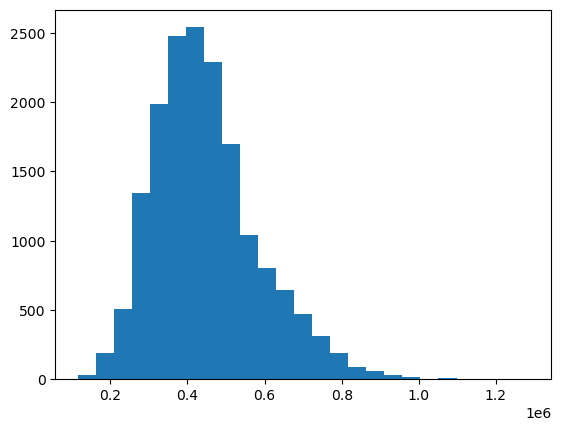

In [175]:
y_pred = ridgecv.predict(Z_hidden)
plt.hist(y_pred, bins=25)  # a bit skewed, but can be roughly taken to be normal

id_df['Predicted'] = y_pred
print(id_df.head())

### 5.5. Export

In [176]:
id_df.to_csv('output/improved_pred.csv', index=False)
# Public score: 43106.84339
# Private score: 42301.95567

---
## 6. Conclusion
---

### 6.1. Addressing the problem statement
* Recap: 
    * Problem statement: as an effort to reduce manual effort and human errors, and to help its estate agents more accurately and timely synthesise large amounts of HDB-resale-flat-related data, the management team of ABC Estate Agency assigned me a task to create a prediction model of HDB resale flats
    * Objective: to create a prediction model of HDB resale flat prices with at least a $R^{2}$ of 0.8
* The objective was achieved: a linear regression model of $R^{2}$ score of 0.9 was developed for ABC Estate Agency
* A minimal data cleaning framework was also proposed to maintain the best model result

### 6.2. Findings
* The baseline linear regression model used on full hdb_train_df (156k rows x 420 columns after one-hot encoding) gave the best model result. This may be due to the already-high cleanliness and nature of the dataset.
* The results of dropping features using Pearson corr coef and ridgecv alpha optimisation supported linear regression as the best model:
    * The more features dropped by increasing p-value threshold from 0.1 to 0.5, the lower all models' cross-val-scores were. Intuitively, this meant that dropping features was not a good idea. In turn, this suggested that the effectiveness of lassocv (known for feature selection) was limited
    * Through alpha optimisation efforts, ridgecv.alpha_ was observed to minimise towards 0. This meant that ridgecv tended towards becoming a linear regression model, since alpha == 0 is equivalent to a linear regression model
* Although the cross-val-score of ridgecv was far better than that of linear regression, the train-test scores were almost the same.
* Although 420 columns were used to fit the best model, which were more than 388 columns (the rule-of-thumb curse of dimensionality limit for the dataset), the model performance on the true blind test via Kaggle was good
* Based on the results of the true blind test, the linear regression model was chosen as the final model to be used for ABC Estate Agency (instead of ridgecv as suggested by the cross-val-score)

### 6.3. Areas for future improvement
* The dataset can be improved by adding several other factors that are intuitively impactful to HDB resale flat prices, such as:
    * Demand and supply data (e.g. number of unsold HDB resale flats (representing supply), number of HDB resale transactions per time period (representing demand))
    * Cooling measures (e.g. duration of wait-out period for private homeowners before purchasing HDB resale flats, loan-to-value limit for HDB loans etc.)

Sources:
* [PropertyGuru - Singapore Property Market Outlook 2023 Overview](https://www.propertyguru.com.sg/property-guides/property-market-outlook-pmo-2023-74042)